# Exploratory Data Analysis

Univariate and bi- or multi-variate analysis of our cleaned data.

## Importing libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

## Import the dataset

Let's import our cleaned (but not one-hotted) dataset. The one-hotting will be useful for more complex algorithms later on.

In [25]:
#converter so that we read as list object and not string
from ast import literal_eval
dataset = pd.read_csv('../Data/cleaned_data.csv', converters={"cuisine_cats": literal_eval})
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2833 non-null   int64  
 1   name          2833 non-null   object 
 2   rating        2833 non-null   float64
 3   latitude      2833 non-null   float64
 4   longitude     2833 non-null   float64
 5   price         2833 non-null   float64
 6   cuisine_cats  2833 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 155.1+ KB


In [26]:
dataset.head(2)

,id,name,rating,latitude,longitude,price,cuisine_cats
0,0,1-V:U,3.5,1.252299,103.820211,40.5,[0]
1,1,10 At Claymore,4.0,1.307401,103.829904,65.5,[1]


`id` is just a unique identifier we have for convenience purposes. `name` is the name of each restaurant. `rating` is the average rating users gave a restaurant. `latitude` and `longitude` are the GPS coordinates of the restaurant. `price` is the middle value of the price range we scraped.

`cuisine_cats` has the most interesting data-type; it is a list of indices into a separate list of cuisines. Let's import this cuisines list.

In [27]:
cuisines = pd.read_csv('../Data/cuisines.csv')
cuisines.describe()

,0
count,52
unique,52
top,Asian Variety
freq,1


We already know some stuff about `cuisine_cats` from our data cleaning, which I will reproduce here.

In [28]:
print("Cuisines: {}".format(len(cuisines)))
print("The most cuisines in a restaurant: {}".format(dataset['cuisine_cats'].apply(len).max()))

Cuisines: 52
The most cuisines in a restaurant: 6


## Univariate analyses

Let's look at each of our variables.

### Univariate analysis of `rating`

We'll start by looking at our summary statistics. Rating is in the form of discrete categories; however, there isa clear numerical ordering, and thus we can to an extent treat it as numerical data.

In [29]:
dataset['rating'].describe()

count    2833.000000
mean        3.623014
std         0.311548
min         2.000000
25%         3.500000
50%         3.500000
75%         4.000000
max         5.000000
Name: rating, dtype: float64

Mean rating is a 3.6, with a standard deviation of 0.31. That means that at least 68% of our restaurants will fall in the 3.0-4.0 rating range. There is no restaurant with a rating below 2.0. The maximum rating is 5.0. The median rating is 3.5. The 25th percentile rating is also 3.5; the 75th percentile is 4.0. At least 50% of our restaurants are thus in the 3.5-4.0 rating range. Let's try looking at a boxplot.

<AxesSubplot:>

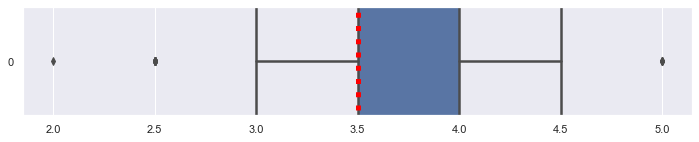

In [39]:
plt.figure(figsize=(12,2))
sb.boxplot(data=dataset['rating'], orient="h", linewidth=2.5, width=16, medianprops={'color': 'red', 'ls': ':', 'lw': 5})

Our boxplot again shows our median to coincide with the 25th percentile. We also know it to be left of the mean, which is 3.6; we are thus seeing a heavy positive skew.  Furthermore, our boxplot's 1.5 IQR whiskers extend from 3.0 to 4.5; it thus seems to be the case that ratings of 2.0, 2.5 and 5.0 are outliers.

Let's try investigating our data further with a histogram of ratings.

<AxesSubplot:xlabel='rating', ylabel='Count'>

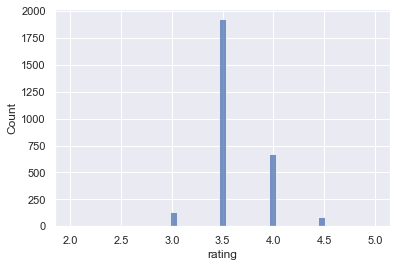

In [30]:
sb.histplot(data=dataset['rating'])

This confirms our understanding that the vast majority of ratings are in the 3.0-4.5 range, and that our distribution is a discrete approximation of a positively skewed normal distribution. A KDE or violin plot would be inappropriate due to the discrete nature of our ratings data, as it would show us a false smoothness. We are thus left with the last thing of interest, which is to find out how the exact percentiles of all our rating values.

In [43]:
from scipy import stats
for i in [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
    print("Percentile <= {} is {:.2f}, > is {:.2f}"
          .format(i,
                  below:=stats.percentileofscore(dataset['rating'],i, kind='weak'),
                  100-below))

Percentile <= 2.0 is 0.04, > is 99.96
Percentile <= 2.5 is 0.60, > is 99.40
Percentile <= 3.0 is 5.15, > is 94.85
Percentile <= 3.5 is 73.07, > is 26.93
Percentile <= 4.0 is 96.75, > is 3.25
Percentile <= 4.5 is 99.79, > is 0.21
Percentile <= 5.0 is 100.00, > is 0.00


0.04% percent of our data is 2.0 or lower. 0.60% of our data is 2.5 or lower. 5.15% of our data is 3.0 or lower. We can thus say that low ratings in the 2.0-3.0 range are exceedingly rare, and restaurants have to be either really terrible or really unlucky to get them.

26.93% of restaurants score 4.0 or higher. 3.25% of restaurants score 4.5 or higher. Only 0.21% of restaurants score a perfect 5.0. We can thus conclude that very high ratings of 4.5-5.0 are likewise very rare.

### Univariate analysis of `latitude`.

In [44]:
dataset['latitude'].describe()

count    2833.000000
mean        1.317245
std         0.036561
min         1.243262
25%         1.292364
50%         1.305143
75%         1.337066
max         1.466940
Name: latitude, dtype: float64

Looks like our standard deviation and min-max range are numerically really small compared to our mean. That makes sense; these are GPS coordinates which give absolute positions on the surface of the Earth, and all of ours are local in a single city (Singapore). It does mean we will need to normalise it to do much with it, though.

<AxesSubplot:>

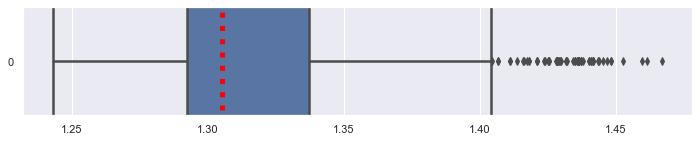

In [51]:
plt.figure(figsize=(12,2))
sb.boxplot(data=dataset['latitude'], orient="h", linewidth=2.5, width=16, medianprops={'color': 'red', 'ls': ':', 'lw': 5})

Looks like we've got positive skew, with median (1.305N) significantly towards the left of the box. This seems to correspond with Singapore having a high density of restaurants and other businesses in the south, with a slow taper as you go north.

There are also a lot of outlier values clustered to the far north, past 1.40N latitude.

<AxesSubplot:>

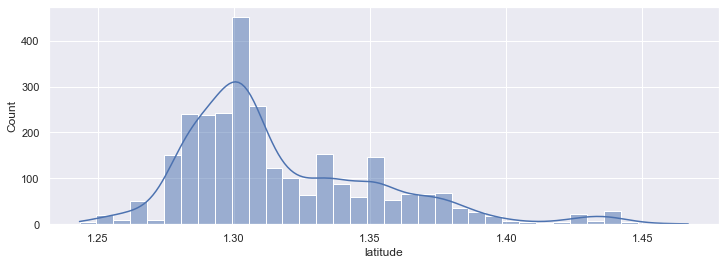

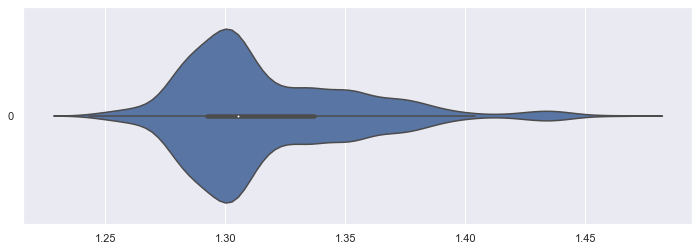

In [70]:
fig, ax = plt.subplots(figsize=(12,4))
sb.histplot(data=dataset['latitude'], kde=True, ax=ax)
fig, ax = plt.subplots(figsize=(12,4))
sb.violinplot(data=dataset['latitude'], orient="h", ax=ax)

Our histogram/KDE and violin plots confirm that our latitude data is roughly normal, but with abnormalities somewhat to the right of the peak which make it rather positively skewed and give it a minor second peak far to the left, in latitude 1.40-1.45, corresponding with the cluster of northern outliers we previously saw. Later on we will more clearly see what could cause this through a geographic visualisation.

### Univariate analysis of `longitude`.

In [71]:
dataset['longitude'].describe()

count    2833.000000
mean      103.843154
std         0.051567
min       103.679230
25%       103.828089
50%       103.844895
75%       103.856858
max       103.990648
Name: longitude, dtype: float64

Looks like our standard deviation and min-max range are numerically really small compared to our mean. That makes sense; these are GPS coordinates which give absolute positions on the surface of the Earth, and all of ours are local in a single city (Singapore). It does mean we will need to normalise it to do much with it, though.

<AxesSubplot:>

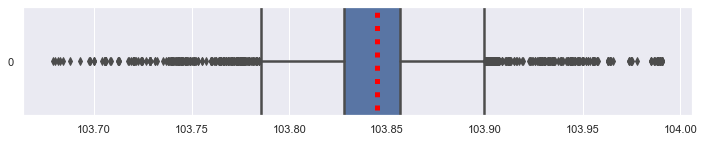

In [72]:
plt.figure(figsize=(12,2))
sb.boxplot(data=dataset['longitude'], orient="h", linewidth=2.5, width=16, medianprops={'color': 'red', 'ls': ':', 'lw': 5})

Looks like we've got slight negative skew, with median (103.844E) somewhat towards the right of the box.

We also seem to have a lot of outliers past the whiskers, this time to both the east and the west of our median.

<AxesSubplot:>

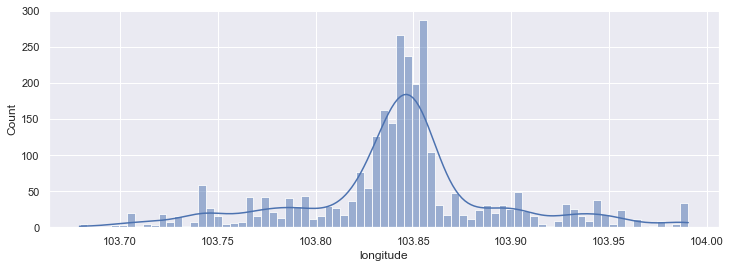

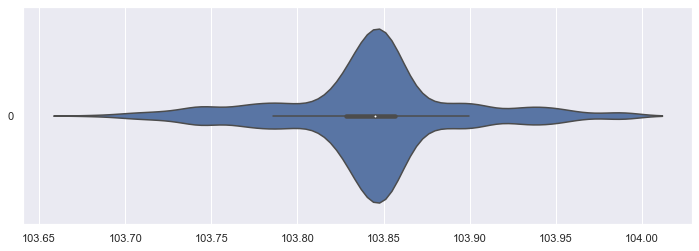

In [73]:
fig, ax = plt.subplots(figsize=(12,4))
sb.histplot(data=dataset['longitude'], kde=True, ax=ax)
fig, ax = plt.subplots(figsize=(12,4))
sb.violinplot(data=dataset['longitude'], orient="h", ax=ax)

Our histogram/KDE and violin plots confirm that our latitude data is roughly a normal distribution with slight skew. However, the tail on both the left and the right tapers slowly and is rather thick, with many outlier values. Let's actually count our outliers.

In [79]:
df = dataset['longitude']
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print("{} outliers to the left/west, {} to the right/east\n"\
      "{} outliers in total, out of {} data points\n"\
      "{:.1f}% of our data points are outliers wrt longitude"
      .format(left := (df < (Q1 - 1.5 * IQR)).sum(),
              right := (df > (Q3 + 1.5 * IQR)).sum(),
              total := left+right,
              lendf := len(df), 100 * total/lendf))

347 outliers to the left/west, 340 to the right/east
687 outliers in total, out of 2833 data points
24.2% of our data points are outliers wrt longitude


24.2% of our data points are outliers by the 1.5\*IQR metric, roughly equally split between outliers to the left and outliers to the right of the media. That's quite a lot and indicates that longitude-wise restaurants are pretty smoothly distributed throughout Singapore, with a peak in the middle.

### Univariate analysis of `cuisine_cats`

This will be interesting and challenging, due to the data type (lists of cuisines) and it being categorical data with a high number of categories.